# Exploring LeafSnap Dataset

In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator


### Create a DataFrame

In [2]:
df = pd.read_csv('leafsnap-dataset-images.txt', sep='\t')
df.head()

# Number of images per species
species_counts = df['species'].value_counts()
print(species_counts.head(10))


species
Maclura pomifera            448
Ulmus rubra                 317
Prunus virginiana           303
Acer rubrum                 297
Broussonettia papyrifera    294
Prunus sargentii            288
Ptelea trifoliata           270
Ulmus pumila                265
Abies concolor              251
Asimina triloba             249
Name: count, dtype: int64


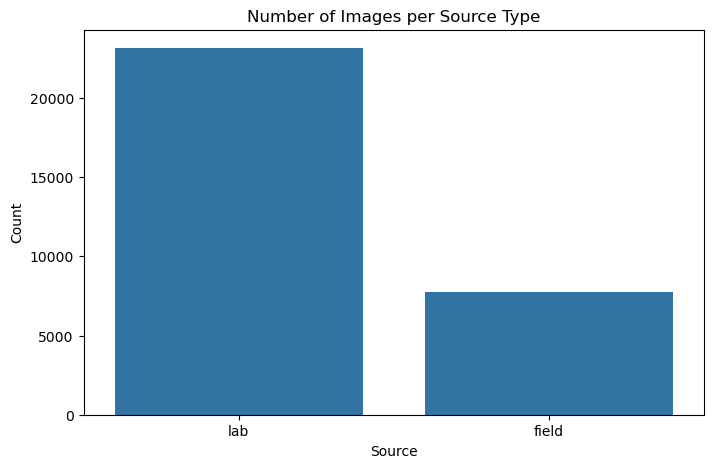

In [3]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='source')
plt.title('Number of Images per Source Type')
plt.xlabel('Source')
plt.ylabel('Count')
plt.show()

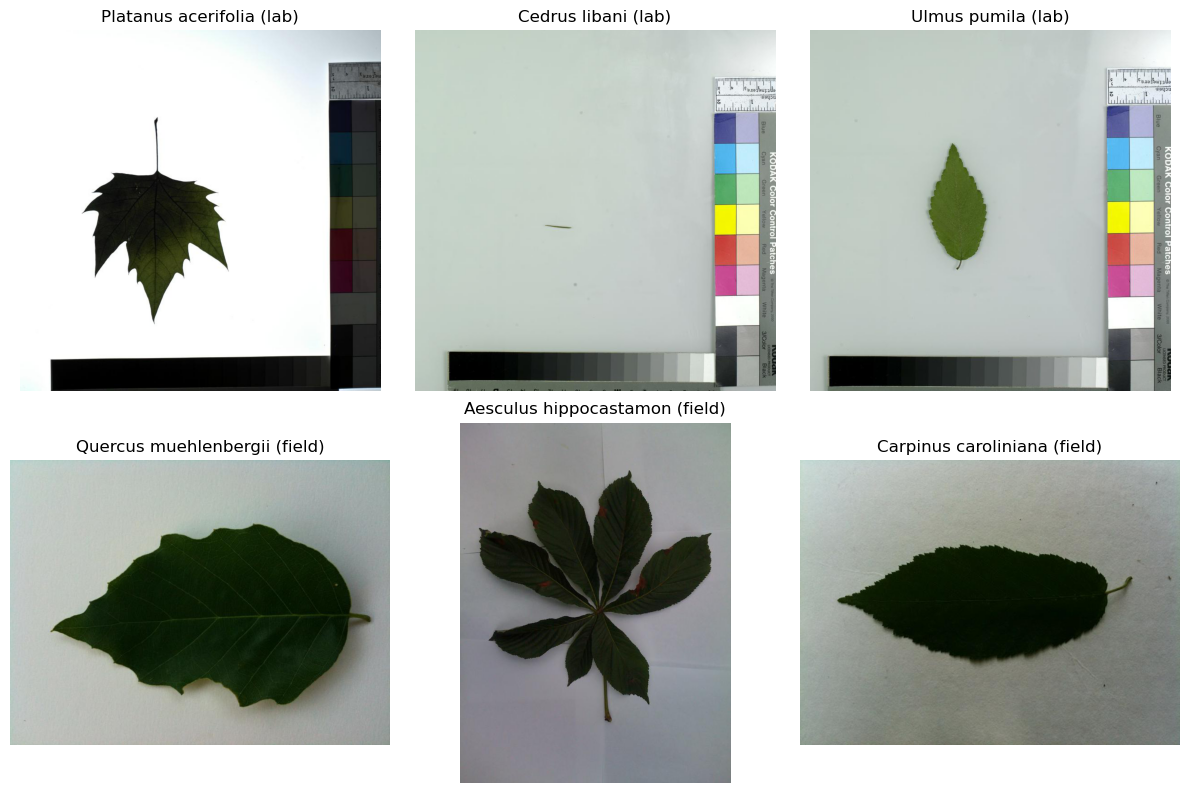

In [4]:

sample = df.sample(6)

plt.figure(figsize=(12, 8))
for i, (_, row) in enumerate(sample.iterrows()):
    img = Image.open(row['image_path'])
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f"{row['species']} ({row['source']})")
    plt.axis('off')

plt.tight_layout()
plt.show()


### Preprocessing

In [5]:
IMG_SIZE = (128, 128)

image_paths = df['segmented_path'].tolist()
labels = df['species'].tolist()

# Encode :D
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(image_paths, encoded_labels, test_size=0.2, stratify=encoded_labels)

# Image loading 
def preprocess_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(lambda x, y: (preprocess_image(x), y)).batch(32).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.map(lambda x, y: (preprocess_image(x), y)).batch(32).prefetch(tf.data.AUTOTUNE)


### Create CNN

In [6]:

basic_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(*IMG_SIZE, 3)),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(label_encoder.classes_), activation='softmax')  # Output layer
])

basic_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

basic_model.summary()


e:\Anaconda\envs\ds325\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 185)            │        23,865 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,328,505 (12.70 MB)

 Trainable params: 3,328,505 (12.70 MB)

 Non-trainable params: 0 (0.00 B)

### Training Montage

In [ ]:
start_time = time.time()
history = basic_model.fit(train_ds, validation_data=test_ds, epochs=10)
end_time = time.time()
seconds = end_time - start_time
minutes = seconds / 60
print(f"Training completed in {seconds:.2f} seconds or {minutes} minutes")

Epoch 1/10
772/772 [==============================] - 96s 124ms/step - loss: 3.9166 - accuracy: 0.1447 - val_loss: 3.2238 - val_accuracy: 0.2446
Epoch 2/10
772/772 [==============================] - 95s 123ms/step - loss: 2.6406 - accuracy: 0.3429 - val_loss: 3.0126 - val_accuracy: 0.2948
Epoch 3/10
772/772 [==============================] - 95s 123ms/step - loss: 1.9441 - accuracy: 0.4909 - val_loss: 3.3232 - val_accuracy: 0.3061
Epoch 4/10
772/772 [==============================] - 95s 123ms/step - loss: 1.4884 - accuracy: 0.5996 - val_loss: 3.7940 - val_accuracy: 0.3009
Epoch 5/10
772/772 [==============================] - 95s 123ms/step - loss: 1.2238 - accuracy: 0.6686 - val_loss: 4.3106 - val_accuracy: 0.2959
Epoch 6/10
772/772 [==============================] - 95s 123ms/step - loss: 1.0767 - accuracy: 0.7056 - val_loss: 4.8824 - val_accuracy: 0.2969
Epoch 7/10
772/772 [==============================] - 95s 123ms/step - loss: 0.9751 - accuracy: 0.7363 - val_loss: 5.2978 - val_ac

### Evaluation

In [7]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.show()

NameError: name 'history' is not defined

## Trying ResNet50
### Preprocessing

In [8]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(lambda x, y: (preprocess_image(x), y)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.map(lambda x, y: (preprocess_image(x), y)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))


### Building the Model

In [9]:
resnet_base_model = tf.keras.applications.ResNet50(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
resnet_base_model.trainable = False

resnet_model = models.Sequential([
    data_augmentation,  # Augment input images
    resnet_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])

resnet_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

resnet_model.build(input_shape=(None, *IMG_SIZE, 3))
resnet_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 185)            │        47,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,159,801 (92.16 MB)

 Trainable params: 572,089 (2.18 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### (Another) Training Montage 

In [11]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

start_time = time.time()
resnet_history = resnet_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=15,
    class_weight=class_weights_dict,
    callbacks=[early_stop]
)
end_time = time.time()
seconds = end_time - start_time
minutes = seconds / 60
print(f"Training completed in {seconds:.2f} seconds or {minutes:.2f} minutes")

Epoch 1/15
772/772 ━━━━━━━━━━━━━━━━━━━━ 701s 908ms/step - accuracy: 0.0129 - loss: 5.0736 - val_accuracy: 0.0364 - val_loss: 4.7776
Epoch 2/15
772/772 ━━━━━━━━━━━━━━━━━━━━ 679s 880ms/step - accuracy: 0.0248 - loss: 4.7988 - val_accuracy: 0.0408 - val_loss: 4.6042
Epoch 3/15
772/772 ━━━━━━━━━━━━━━━━━━━━ 675s 874ms/step - accuracy: 0.0336 - loss: 4.6367 - val_accuracy: 0.0395 - val_loss: 4.5530
Epoch 4/15
772/772 ━━━━━━━━━━━━━━━━━━━━ 696s 901ms/step - accuracy: 0.0416 - loss: 4.5483 - val_accuracy: 0.0538 - val_loss: 4.4335
Epoch 5/15
772/772 ━━━━━━━━━━━━━━━━━━━━ 710s 919ms/step - accuracy: 0.0421 - loss: 4.4797 - val_accuracy: 0.0615 - val_loss: 4.3481
Epoch 6/15
772/772 ━━━━━━━━━━━━━━━━━━━━ 687s 889ms/step - accuracy: 0.0483 - loss: 4.4430 - val_accuracy: 0.0666 - val_loss: 4.3332
Epoch 7/15
772/772 ━━━━━━━━━━━━━━━━━━━━ 671s 869ms/step - accuracy: 0.0500 - loss: 4.4023 - val_accuracy: 0.0667 - val_loss: 4.2890
Epoch 8/15
772/772 ━━━━━━━━━━━━━━━━━━━━ 670s 867ms/step - accuracy: 0.0538 -

### Evaluation

193/193 ━━━━━━━━━━━━━━━━━━━━ 142s 736ms/step - accuracy: 0.0778 - loss: 4.2127
Test Accuracy: 0.08


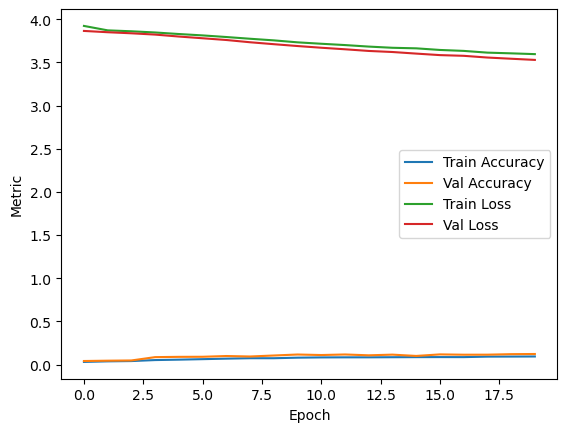

In [27]:
test_loss, test_acc = resnet_model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

# Plot accuracy and loss curves
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.show()


## Trying MobileNetV2

In [ ]:
species_counts = df['species'].value_counts()
species_to_keep = species_counts[species_counts >= 175].index

df_filtered = df[df['species'].isin(species_to_keep)].reset_index(drop=True)

print(f"Original classes: {df['species'].nunique()}")
print(f"Remaining classes: {df_filtered['species'].nunique()}")
print(f"Remaining images: {len(df_filtered)}")

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df_filtered['species'])

IMG_SIZE = (224, 224)

X_train, X_val, y_train, y_val = train_test_split(
    df_filtered['segmented_path'].values,
    encoded_labels,
    test_size=0.2,
    stratify=encoded_labels,
    random_state=42
)

def preprocess_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top-5-accuracy')]
)

model.summary()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Original classes: 185
Remaining classes: 49
Remaining images: 10892
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 49)             │        12,593 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,598,513 (9.91 MB)

 Trainable params: 340,529 (1.30 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 107s 370ms/step - accuracy: 0.0257 - loss: 3.9897 - top-5-accuracy: 0.1153 - val_accuracy: 0.0413 - val_loss: 3.8654 - val_top-5-accuracy: 0.1528
Epoch 2/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 95s 349ms/step - accuracy: 0.0389 - loss: 3.8780 - top-5-accuracy: 0.1419 - val_accuracy: 0.0450 - val_loss: 3.8504 - val_top-5-accuracy: 0.1739
Epoch 3/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 94s 345ms/step - accuracy: 0.0381 - loss: 3.8650 - top-5-accuracy: 0.1557 - val_accuracy: 0.0477 - val_loss: 3.8380 - val_top-5-accuracy: 0.1730
Epoch 4/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 95s 346ms/step - accuracy: 0.0499 - loss: 3.8493 - top-5-accuracy: 0.1683 - val_accuracy: 0.0863 - val_loss: 3.8230 - val_top-5-accuracy: 0.2139
Epoch 5/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 95s 347ms/step - accuracy: 0.0533 - loss: 3.8380 - top-5-accuracy: 0.1825 - val_accuracy: 0.0895 - val_loss: 3.8004 - val_top-5-accuracy: 0.2198
Epoch 6/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 95s 348ms/step - accuracy: 0.0584 

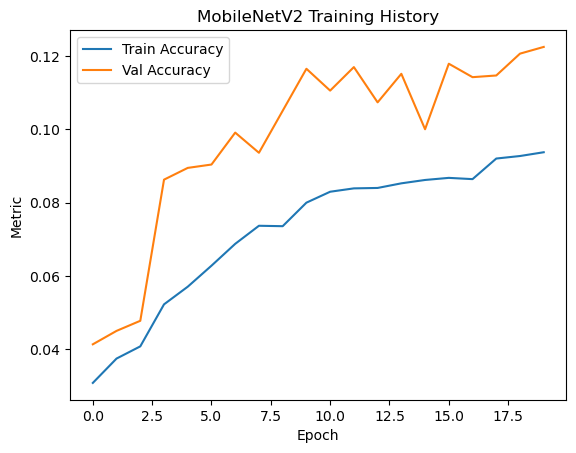

In [26]:
mobileNetV2_history = history
plt.plot(mobileNetV2_history.history['accuracy'], label='Train Accuracy')
plt.plot(mobileNetV2_history.history['val_accuracy'], label='Val Accuracy')
plt.title('MobileNetV2 Training History')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.show()